To make this notebook reproducible, please change the paths to the files from the handout!


##Import Packages

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from matplotlib import image
import matplotlib.pyplot as plt

import matplotlib as mpl

import zipfile
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm import tqdm
import shutil

# Load the dataset

In [2]:
train_triplets_path = '/content/drive/MyDrive/ml_task4/train_triplets.txt'
test_triplets_path = '/content/drive/MyDrive/ml_task4/test_triplets.txt'
food_path = '/content/drive/MyDrive/ml_task4/food.zip'

In [3]:
# from google.colab import auth
# auth.authenticate_user()

# project_id = 'dynamic-fulcrum-314308'
# !gcloud config set project {project_id}

# from google.colab import drive
# drive.mount('/content/drive')

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

Mounted at /content/drive


read the training/test triplets

In [4]:
train_triplets = pd.read_csv(train_triplets_path, delim_whitespace=True, header=None, names =['anchor','positive','negative'])
test_triplets = pd.read_csv(test_triplets_path, delim_whitespace=True, header=None, names =['anchor','positive','negative'])

unzip the food images

In [ ]:
with zipfile.ZipFile(food_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print('Extracted images to directory.')

Extracted images on local drive.


#Generate resized images

In [ ]:
img_path = r'/content/food'
image_resized_path = r'/content/food_res/img'
if not os.path.exists(image_resized_path):
  os.makedirs(image_resized_path)

img_height = 299
img_width = 299

##Skip if resized images already exist

resize all images to have the same size, use padding if necessary

In [ ]:
for img_name in tqdm(os.listdir(img_path)):
  if img_name.endswith('.jpg'):
    img = load_img(img_path + '/' + img_name)
    img = img_to_array(img)
    img = tf.image.resize_with_pad(img, img_height, img_width, antialias=True)
    img = array_to_img(img)
    img.save(image_resized_path + '/' + img_name)

100%|██████████| 10001/10001 [02:00<00:00, 82.76it/s]

Resized images and saved to new directory.


In [ ]:
# shutil.make_archive('/content/food_res/img', 'zip', image_resized_path)

'/content/food_res.zip'

In [ ]:
# !gsutil cp food_res.zip gs://intro-ml-task4-fs21-permanent

Copying file://food_res.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][157.0 MiB/157.0 MiB]                                                
Operation completed over 1 objects/157.0 MiB.                                    


##Run if resized images already in bucket

In [ ]:
# !gsutil cp gs://intro-ml-task4-fs21-permanent/food_res.zip .

# !unzip -q food_res.zip -d '/content/food_res/img'

# !rm food_res.zip

Copying gs://intro-ml-task4-fs21-permanent/food_res.zip...
| [1 files][157.0 MiB/157.0 MiB]                                                
Operation completed over 1 objects/157.0 MiB.                                    


#Feature Extraction

In [ ]:
input_shape = (299,299,3)

features_file = 'features.npy'

# Generate Dataset
train_res = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/food_res',
    label_mode=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(299, 299),
    shuffle=False
)

#base_model_Xception = tf.keras.applications.Xception(include_top=False, weights="imagenet", pooling='avg')
base_model_inception = tf.keras.applications.InceptionResNetV2(pooling='avg',include_top=False)

# freeze the weights
#base_model_Xception.trainable=False
base_model_inception.trainable=False

# declare input
inputs = Input(shape=input_shape)
#x = tf.keras.applications.xception.preprocess_input(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
#outputs = base_model_Xception(x)
outputs = base_model_inception(x)

#obtain model and return
base_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compute features
features = base_model.predict(train_res)

Found 10000 files belonging to 1 classes.


##save features for future use

In [ ]:
# features_file_xception = 'features_xception.npy'
# with open(features_file, 'wb') as f:
#   np.save(f, features)

In [ ]:
# # run if not yet uploaded
# if os.path.exists(features_file_xception):
#   !gsutil cp features_xception.npy gs://intro-ml-task4-fs21-permanent

Copying file://features_xception.npy [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/78.1 MiB.                                     


##If features already extracted

In [5]:
# !gsutil cp gs://intro-ml-task4-fs21-permanent/features.npy .

# features = np.load('features.npy')

Copying gs://intro-ml-task4-fs21-permanent/features.npy...
- [1 files][ 58.6 MiB/ 58.6 MiB]                                                
Operation completed over 1 objects/58.6 MiB.                                     


# Create Triplet tensor 

In [6]:
df = train_triplets.copy()
df_switched = df[['anchor', 'negative', 'positive']]
df_switched = df_switched.rename(columns={"anchor": "anchor", "negative": "positive", 'positive': 'negative'})

df['label'] = 1
df_switched['label'] = 0

df_combined = pd.concat([df, df_switched])
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# df_train, df_val = train_test_split(df_combined, test_size=0.2)

In [7]:
def generate_feature_tensor(features, triplet_df, train=False):
  if train:
    train_tensor = np.zeros((triplet_df.shape[0],3*features.shape[1]))
    labels = np.empty(0)

    for i in tqdm(range(triplet_df.shape[0])):
      anchor, positive, negative, label = triplet_df.iloc[i,:]

      triplet_features = np.concatenate([features[int(anchor),:],features[int(positive),:],features[int(negative),:]])
      train_tensor[i] = triplet_features
      labels = np.append(labels, label)

    return train_tensor, labels

  else:
    test_tensor = np.zeros((triplet_df.shape[0],3*features.shape[1]))
    for i in tqdm(range(triplet_df.shape[0])):
      anchor, positive, negative = triplet_df.iloc[i,:]

      triplet_features = np.concatenate([features[int(anchor),:],features[int(positive),:],features[int(negative),:]])
      test_tensor[i] = triplet_features

    return test_tensor

In [8]:
train_tensor, labels = generate_feature_tensor(features, df_combined, train=True)

100%|██████████| 119030/119030 [00:34<00:00, 3460.07it/s]


In [7]:
# train_tensor, labels = generate_feature_tensor(features, df_train, train=True)
# val_tensor, val_labels = generate_feature_tensor(features, df_val, train=True)

100%|██████████| 23806/23806 [00:03<00:00, 6039.86it/s]


##GENERATOR VERSION

generator version for large feature file

In [ ]:
# def tensor_from_feature_file(triplet_df, features, batch_size):
#     # Image indices
#     num_triplets = triplet_df.shape[0]
#     features_length = features.shape[1]
#     # Current idx
#     curr_idx = 0

#     while True:
#         batch = np.empty((0, 3*features_length))
#         labels = []

#         while len(batch) < batch_size:
#             anchor, positive, negative, label = triplet_df.iloc[curr_idx,:]

#             feature = np.concatenate((features[int(anchor)], features[int(positive)], features[int(negative)]))
#             batch = np.vstack((batch,feature))
#             labels.append(label)
#             curr_idx = (curr_idx + 1) % num_triplets

#         yield (batch, np.array(labels))

# # Initialize generator
# train_tensor_gen = tensor_from_feature_file(df_train, features, 32)
# val_tensor_gen = tensor_from_feature_file(df_val, features, 32)

#Build model

In [10]:
input = Input(train_tensor.shape[1:])
x = Activation('relu')(input)
x = Dropout(0.7)(x)
x = Dense(1152)(x)
x = Activation('relu')(x)
x = Dense(288)(x)
x = Activation('relu')(x)
x = Dense(72)(x)
x = Activation('relu')(x)
x = Dense(18)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)
model = Model(inputs=input, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# BS = 32
# NUM_TRAIN_IMAGES = df_train.shape[0]
# NUM_VAL_IMAGES = df_val.shape[0]

# history = model.fit(x=train_tensor_gen, validation_data=val_tensor_gen, epochs=5, steps_per_epoch=NUM_TRAIN_IMAGES // BS, validation_steps=NUM_VAL_IMAGES // BS)

In [11]:
history = model.fit(x=train_tensor, y=labels, epochs=5, )

Epoch 1/5
3720/3720 [==============================] - 148s 39ms/step - loss: 0.6215 - accuracy: 0.6421
Epoch 2/5
3720/3720 [==============================] - 146s 39ms/step - loss: 0.5884 - accuracy: 0.6805
Epoch 3/5
3720/3720 [==============================] - 155s 42ms/step - loss: 0.5808 - accuracy: 0.6892
Epoch 4/5
3720/3720 [==============================] - 154s 41ms/step - loss: 0.5744 - accuracy: 0.6926
Epoch 5/5
3720/3720 [==============================] - 147s 40ms/step - loss: 0.5698 - accuracy: 0.6963


##visualize training

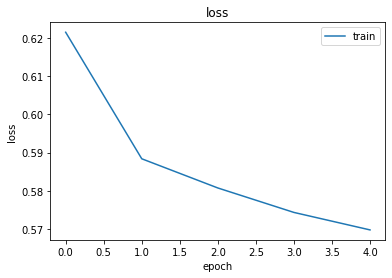

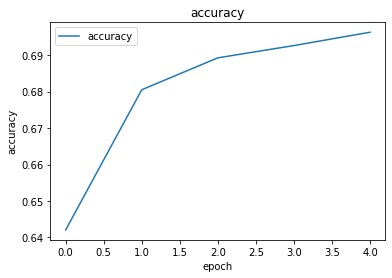

In [12]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'], label='train')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
#plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

##Make prediction

In [13]:
#because of RAM limitations
del train_tensor

test_tensor = generate_feature_tensor(features, test_triplets, train=False)

# Predict
predictions = model.predict(test_tensor)

100%|██████████| 59544/59544 [00:09<00:00, 6301.66it/s]


In [14]:
# Create submission file
np.savetxt('submission.txt', np.where(predictions < 0.5, 0, 1), fmt='%d')